In [1]:
import pandas as pd
import numpy as np
from geopy.distance import geodesic
import matplotlib.pyplot as plt

# Chargement des données
df = pd.read_excel("test_marguerite.xlsx")

In [2]:
df.shape

(1926, 7)

In [3]:
df.head()

,Horaire.de.départ,Horaire.d.arrivée,Vitesse..en.km.h.,xdep,ydep,xarr,yarr
0,2025-03-03 07:44:21,2025-03-03 07:44:29,6,2.37543,48.91359,2.37481,48.91367
1,2025-03-03 07:44:29,2025-03-03 07:44:39,17,2.37481,48.91367,2.37414,48.91367
2,2025-03-03 07:44:39,2025-03-03 07:44:45,17,2.37414,48.91367,2.37397,48.91358
3,2025-03-03 07:44:45,2025-03-03 07:44:47,9,2.37397,48.91358,2.37397,48.91352
4,2025-03-03 07:44:47,2025-03-03 07:45:12,10,2.37397,48.91352,2.37474,48.91230


In [4]:
# Types des colonnes
print(df.dtypes)

Horaire.de.départ    datetime64[ns]
Horaire.d.arrivée    datetime64[ns]
Vitesse..en.km.h.             int64
xdep                        float64
ydep                        float64
xarr                        float64
yarr                        float64
dtype: object


In [5]:
# Valeurs manquantes
print(df.isnull().sum())

Horaire.de.départ    0
Horaire.d.arrivée    0
Vitesse..en.km.h.    0
xdep                 0
ydep                 0
xarr                 0
yarr                 0
dtype: int64


In [6]:
# Comptage des valeurs uniques
print(df.nunique())

Horaire.de.départ    1885
Horaire.d.arrivée    1885
Vitesse..en.km.h.      73
xdep                 1322
ydep                 1199
xarr                 1322
yarr                 1199
dtype: int64


In [7]:
# Valeurs aberrantes pour la vitesse
print(df["Vitesse..en.km.h."].describe())

count    1926.000000
mean       12.651090
std        14.275208
min         0.000000
25%         0.000000
50%         9.000000
75%        18.000000
max        75.000000
Name: Vitesse..en.km.h., dtype: float64


Pas de valeurs aberrantes ou négatives

In [8]:
# Changement des noms de variables car elles contiennent des accents ou des majuscules
df = df.rename(columns={
    "Horaire.de.départ": "horaire_depart",
    "Horaire.d.arrivée": "horaire_arrivee",
    "Vitesse..en.km.h.": "vitesse_kmh"
})

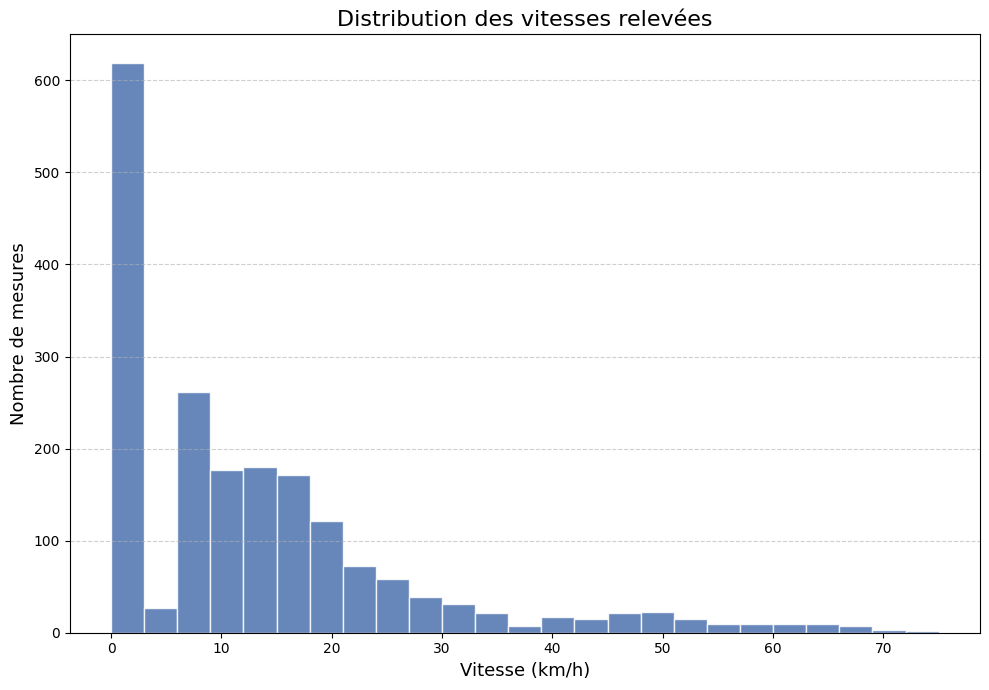

In [9]:
plt.figure(figsize=(10,7))
plt.hist(df['vitesse_kmh'].dropna(), bins=25, color="#4C72B0", edgecolor="white", alpha=0.85)
plt.title("Distribution des vitesses relevées", fontsize=16)
plt.xlabel("Vitesse (km/h)", fontsize=13)
plt.ylabel("Nombre de mesures", fontsize=13)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [10]:
# Conversion des horaires de départ/arrivée
df['horaire_depart'] = pd.to_datetime(df['horaire_depart'])
df['horaire_arrivee'] = pd.to_datetime(df['horaire_arrivee'])

In [11]:
# Calcul de durées et autres variables temporelles potentiellement utiles
df["duree_minutes"] = (df["horaire_arrivee"] - df["horaire_depart"]).dt.total_seconds() / 60
df["date"] = df["horaire_depart"].dt.date
df["heure"] = df["horaire_depart"].dt.hour
df["jour_semaine"] = df["horaire_depart"].dt.day_name()

In [12]:
df.date.value_counts()

date
2025-03-03    528
2025-03-07    448
2025-03-05    421
2025-03-04    280
2025-03-06    249
Name: count, dtype: int64

In [13]:
df.heure.value_counts()

heure
15    277
8     269
10    218
13    211
9     204
12    176
11    166
14    147
7     140
16    118
Name: count, dtype: int64

# Les données de cet exercice correspondent aux traces GPS des déplacements quotidiens d’un artisan, enregistrées pendant une semaine complète (du lundi au vendredi). Le capteur est activé uniquement la journée.

In [14]:
# Trouver tous les points d'arrêt (vitesse = 0)
points_arret = df[df["vitesse_kmh"] == 0].copy()

# Calculer l'écart de temps entre chaque point d'arrêt consécutif
points_arret["ecart_temps_s"] = points_arret["horaire_depart"].diff().dt.total_seconds()

# Identifier le début d'un nouvel arrêt
# Un nouvel arrêt commence quand c'est le premier point & que l'écart avec le point précédent > 2 minutes
points_arret["nouveau_arret"] = (points_arret["ecart_temps_s"] > 120) | (points_arret["ecart_temps_s"].isna())

# Attribuer un numéro unique à chaque arrêt
points_arret["numero_arret"] = points_arret["nouveau_arret"].cumsum()

# Calculer les infos utiles de chaque arrêt
arrets_stats = points_arret.groupby("numero_arret").agg({
    "horaire_depart": ["min", "max"],  # Heure début et fin
    "xdep": "first",                   # Position (première occurrence)
    "ydep": "first"
}).reset_index()

# Simplifier les noms de colonnes
arrets_stats.columns = ["numero_arret", "heure_debut", "heure_fin", "xdep", "ydep"]

# Calculer la durée de chaque arrêt
arrets_stats["duree_s"] = (arrets_stats["heure_fin"] - arrets_stats["heure_debut"]).dt.total_seconds()

# 1. Identifier les différents arrêts du véhicule 

In [15]:
print(f"Nombre de points avec vitesse = 0 : {len(points_arret)}")

Nombre de points avec vitesse = 0 : 605


# 2. Calculer le nombre d'arrêts du véhicule 

In [16]:
print(f"Nombre d'arrêts détectés : {points_arret['numero_arret'].nunique()}")

Nombre d'arrêts détectés : 225


# 3. Calculer les durées des arrêts du véhicule 

In [17]:
# Résumé par arrêt
resume_arrets = arrets_stats.groupby("numero_arret").agg(
    debut=("heure_debut", "first"),
    fin=("heure_fin", "last"),
    duree_totale_s=("duree_s", "sum"),
    x=("xdep", "first"),
    y=("ydep", "first")
).reset_index()

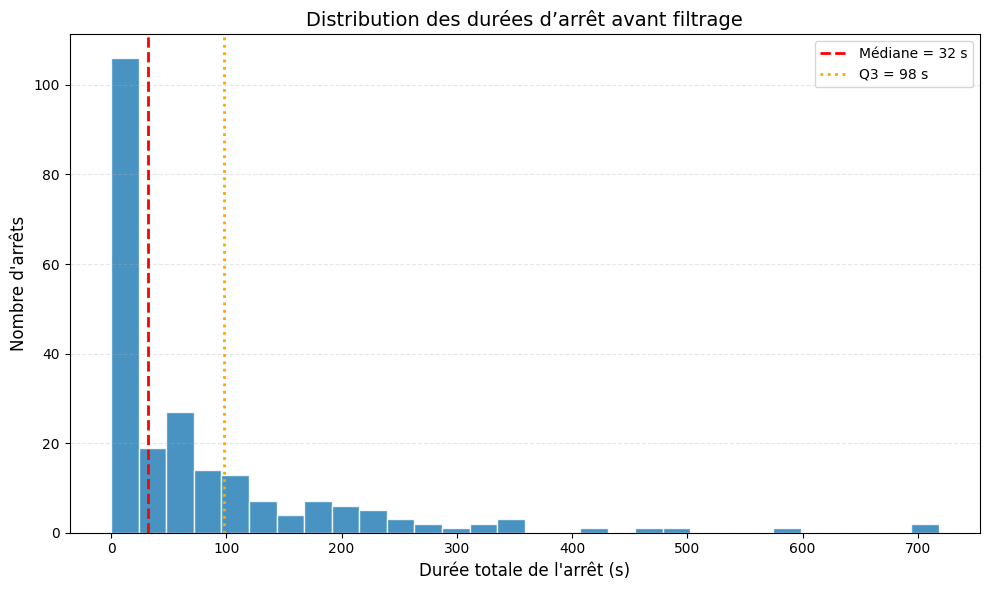

In [18]:
#histograme des arrêts
data = resume_arrets['duree_totale_s'].dropna()
fig, ax = plt.subplots(figsize=(10,6))

n, bins, patches = ax.hist(data, bins=30, color='#2980b9', edgecolor='white', alpha=0.85)

# Ligne médiane
med = np.median(data)
ax.axvline(med, color='red', linestyle='dashed', linewidth=2, label=f"Médiane = {int(med)} s")

# Ligne quantile 0.75 pour repérer les 'longs' arrêts
q3 = np.percentile(data, 75)
ax.axvline(q3, color='orange', linestyle='dotted', linewidth=2, label=f"Q3 = {int(q3)} s")

ax.set_title("Distribution des durées d’arrêt avant filtrage", fontsize=14)
ax.set_xlabel("Durée totale de l'arrêt (s)", fontsize=12)
ax.set_ylabel("Nombre d'arrêts", fontsize=12)
ax.grid(axis='y', linestyle='--', alpha=0.3)
ax.legend()
plt.tight_layout()
plt.show()


On constate que la majorité des arrêts durent 0 seconde, il ne s'agit pas là d'arrêts interessants

In [19]:
# FILTRER les arrêts trop courts (< 90 secondes)
# car la durée moyenne d'un feu rouge est de 90 secondes
print(f"Arrêts avant filtrage : {len(resume_arrets)}")
arrets_significatifs = resume_arrets[resume_arrets["duree_totale_s"] >= 90].copy()
print(f"Arrêts significatifs (≥90s) : {len(arrets_significatifs)}")
print(f"Arrêts filtrés : {len(arrets_stats) - len(arrets_significatifs)}")

Arrêts avant filtrage : 225
Arrêts significatifs (≥90s) : 62
Arrêts filtrés : 163


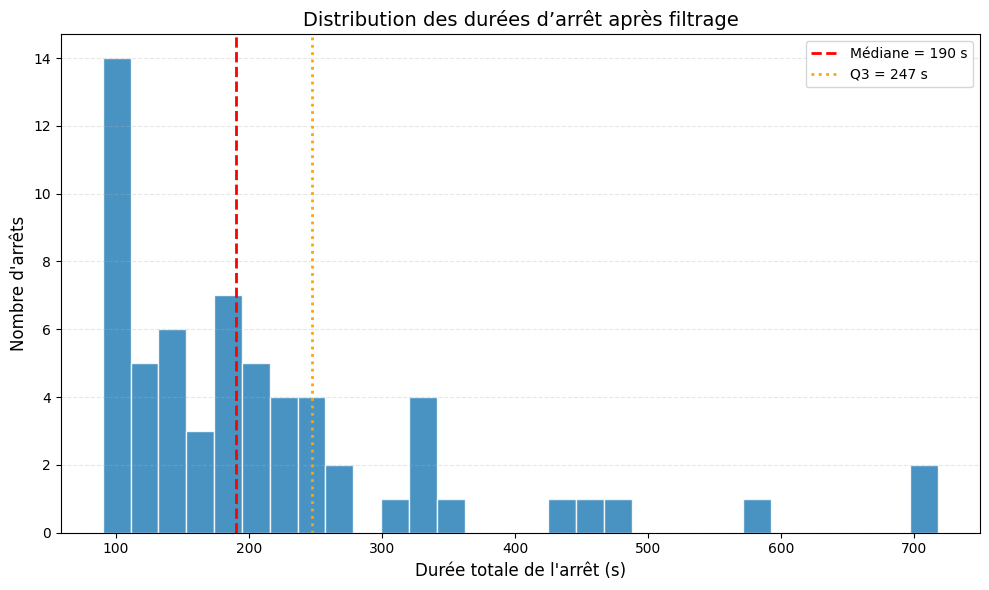

In [20]:
#histograme des arrêts significatifs
data = arrets_significatifs['duree_totale_s'].dropna()
fig, ax = plt.subplots(figsize=(10,6))

n, bins, patches = ax.hist(data, bins=30, color='#2980b9', edgecolor='white', alpha=0.85)

# Ligne médiane
med = np.median(data)
ax.axvline(med, color='red', linestyle='dashed', linewidth=2, label=f"Médiane = {int(med)} s")

# Ligne quantile 0.75 pour repérer les 'longs' arrêts
q3 = np.percentile(data, 75)
ax.axvline(q3, color='orange', linestyle='dotted', linewidth=2, label=f"Q3 = {int(q3)} s")

ax.set_title("Distribution des durées d’arrêt après filtrage", fontsize=14)
ax.set_xlabel("Durée totale de l'arrêt (s)", fontsize=12)
ax.set_ylabel("Nombre d'arrêts", fontsize=12)
ax.grid(axis='y', linestyle='--', alpha=0.3)
ax.legend()
plt.tight_layout()
plt.show()


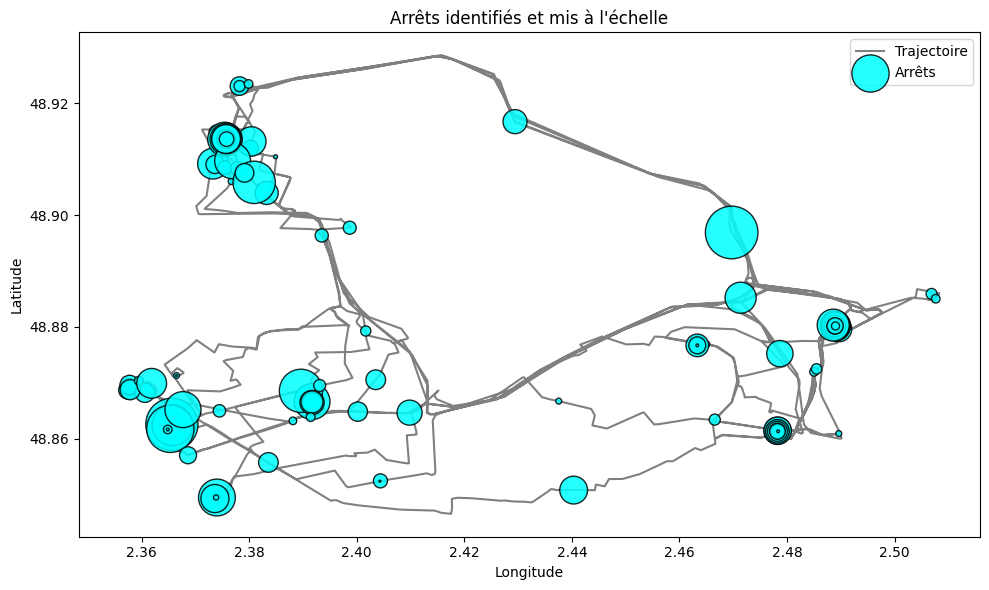

In [22]:
plt.figure(figsize=(10, 6))

# Trace la trajectoire
plt.plot(df["xdep"], df["ydep"], color="gray", label="Trajectoire", zorder=1)

# On augmente la taille des points et leur différence
taille_points = resume_arrets["duree_totale_s"] * 2  # ajuste le facteur pour lisibilité

plt.scatter(
    resume_arrets["x"],
    resume_arrets["y"],
    s=taille_points,   # taille dépend de la durée de l'arrêt
    color="cyan",
    alpha=0.85,
    edgecolor="k",
    label="Arrêts"
)

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Arrêts identifiés et mis à l'échelle")
plt.legend()
plt.tight_layout()
plt.show()


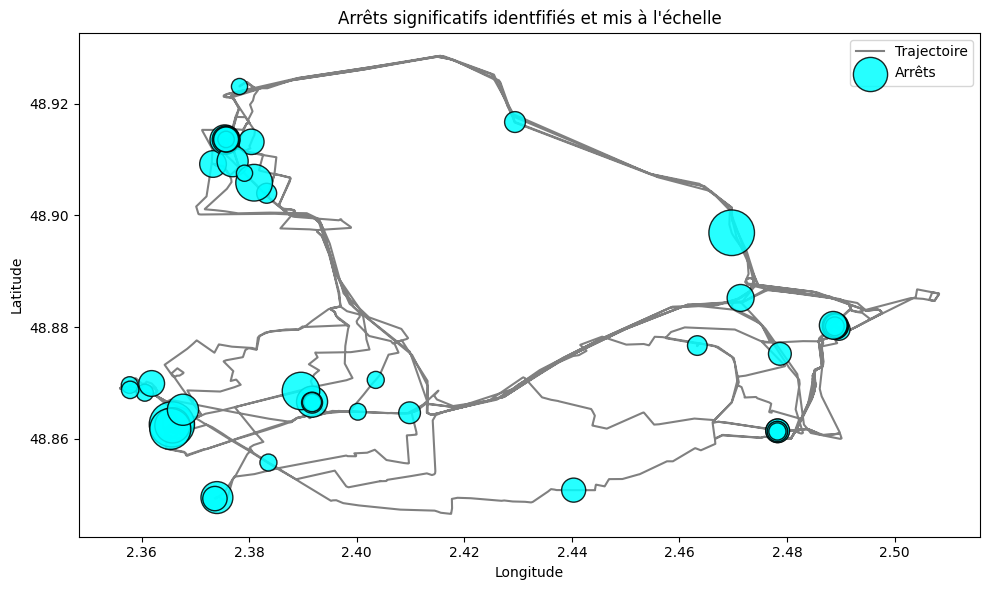

In [23]:
# Arrets_significatifs > 90s
plt.figure(figsize=(10, 6))

# Trace la trajectoire
plt.plot(df["xdep"], df["ydep"], color="gray", label="Trajectoire", zorder=1)

# On augmente la taille des points et leur différence
taille_points = arrets_significatifs["duree_totale_s"] * 1.5  # ajuste le facteur pour lisibilité

plt.scatter(
    arrets_significatifs["x"],
    arrets_significatifs["y"],
    s=taille_points,   # taille dépend de la durée de l'arrêt
    color="cyan",
    alpha=0.85,
    edgecolor="k",
    label="Arrêts"
)

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Arrêts significatifs identfifiés et mis à l'échelle")
plt.legend()
plt.tight_layout()
plt.show()


# 4. Déterminer les distances parcourues entre les arrêts.

In [24]:
# Décalage des coordonnées pour obtenir les positions précédentes
resume_arrets["x_prec"] = resume_arrets["x"].shift()
resume_arrets["y_prec"] = resume_arrets["y"].shift()

# Calcul des distances entre chaque arrêt (en mètres)
def distance_between_points(row):
    if pd.isna(row["x_prec"]) or pd.isna(row["y_prec"]):
        return np.nan
    return geodesic((row["y_prec"], row["x_prec"]), (row["y"], row["x"])).meters

resume_arrets["distance_m"] = resume_arrets.apply(distance_between_points, axis=1)

# Distance totale parcourue entre les arrêts (en kilomètres)
distance_totale_km = resume_arrets["distance_m"].sum() / 1000

print(f"Distance totale parcourue entre les arrêts : {distance_totale_km:.2f} km")

           x         y   distance_m
0    2.38492  48.91045          NaN
1    2.47867  48.87523  7912.039292
2    2.47823  48.86124  1556.123360
3    2.47823  48.86124     0.000000
4    2.44033  48.85083  3012.512471
..       ...       ...          ...
220  2.38210  48.90469   107.656664
221  2.38093  48.90586   155.841277
222  2.37914  48.90756   230.131310
223  2.37745  48.91214   524.182012
224  2.37581  48.91359   201.128740

[225 rows x 3 columns]
Distance totale parcourue entre les arrêts : 188.25 km


# Classification des arrêts

Le capteur GPS étant activé uniquement la journée, je suppose que les arrêts de type "garage" sont les premiers et les derniers de la journée

In [29]:
arrets_significatifs["date"] = arrets_significatifs["debut"].dt.date

In [31]:
# On trie
arrets_significatifs = arrets_significatifs.sort_values(['date', 'debut'])

first_index = arrets_significatifs.groupby('date').head(1).index
last_index  = arrets_significatifs.groupby('date').tail(1).index


In [34]:
def type_arret_v2(row):
    if row.name in first_index or row.name in last_index:
        return "garage"
    if row["duree_totale_s"] > 120:
        return "chantier"
    return "achat"

arrets_significatifs['type'] = arrets_significatifs.apply(type_arret_v2, axis=1)

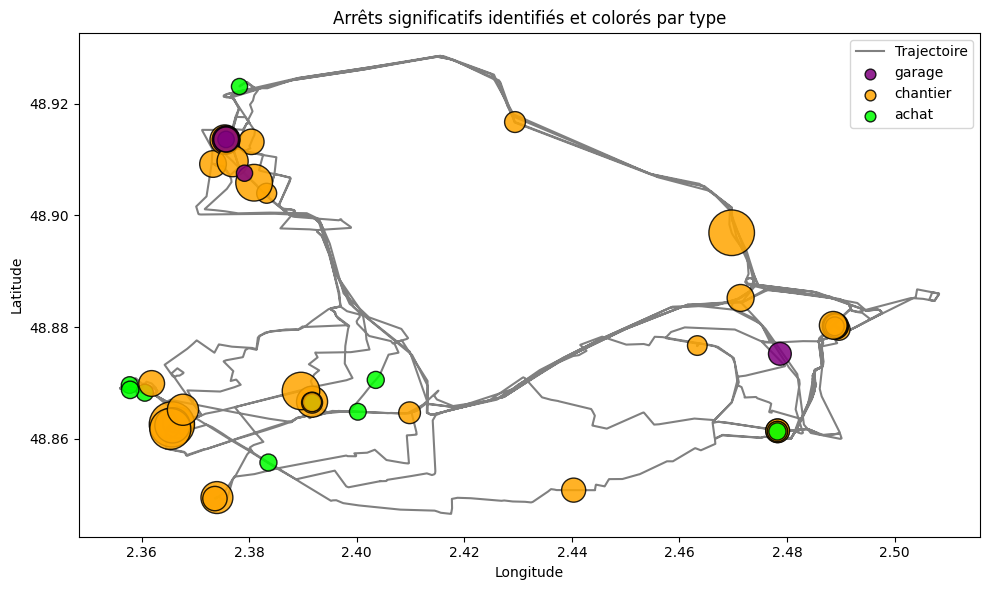

In [36]:
type_to_color = {"garage": "purple", "chantier": "orange", "achat": "lime"}
colors = arrets_significatifs["type"].map(type_to_color).fillna("gray")

plt.figure(figsize=(10, 6))

# Trajectoire
plt.plot(df["xdep"], df["ydep"], color="gray", label="Trajectoire", zorder=1)

# on augmente la taille des points et leur différence
taille_points = arrets_significatifs["duree_totale_s"] * 1.5

# Points colorés selon le type d'arrêt
plt.scatter(
    arrets_significatifs["x"],
    arrets_significatifs["y"],
    s=taille_points,
    color=colors,
    alpha=0.85,
    edgecolor="k"
)

# correction de la légende
for arret_type, color in type_to_color.items():
    plt.scatter([], [], s=60, color=color, label=arret_type, alpha=0.85, edgecolor="k")
    
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Arrêts significatifs identifiés et colorés par type")
plt.legend()
plt.tight_layout()
plt.show()
